# **Hands-On \#2:** Image-Text Search (CLIP)

by Romrawin Chumpu (Jinpu)

AI Lecture - Modern Image Search

Date: January 30, 2024

Sources:
- Open CLIP: https://github.com/mlfoundations/open_clip

In [ ]:
!pip -q install datasets open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Download dataset

**Food101** will be used (https://huggingface.co/datasets/food101)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("food101")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
### Dataset Information ###
print("### Dataset Information ###\n")
print("Number of training images: ", len(dataset["train"]))
print("Number of labels: ", len(dataset["train"].features["label"].names))

### Dataset Information ###

Number of training images:  75750
Number of labels:  101


In [ ]:
id2label = {}
for i, label in enumerate(dataset["train"].features["label"].names):
  id2label[i] = label

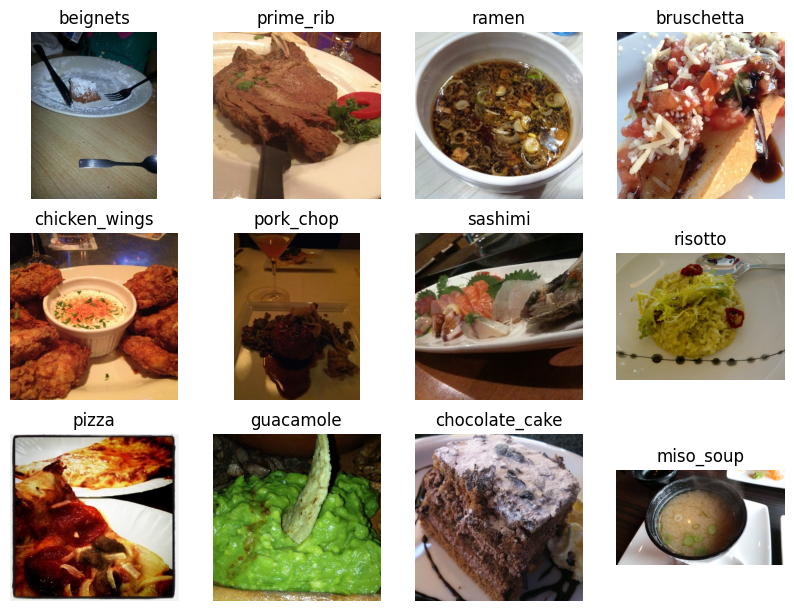

In [ ]:
rows = 4; cols = 4
fig = plt.figure(figsize=(10, 10))
c = 0
for i in range(0, 12000, 1000):
  ax = fig.add_subplot(rows, cols, c+1)
  image = dataset["train"][i]["image"]
  plt.imshow(image)
  plt.axis('off')
  plt.title(id2label[dataset["train"][i]["label"]])
  c+=1
plt.show()

# Load CLIP Pretrained model

In [ ]:
import open_clip

In [ ]:
model_name = 'ViT-B-32-quickgelu'
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(model_name,
                                                             device = device,
                                                             pretrained='openai')
tokenizer = open_clip.get_tokenizer(model_name)

100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 68.8MiB/s]


In [ ]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

# Offline Stage



In [ ]:
# subset dataset
num_samples = 1000
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

In [ ]:
def extract_embeddings(model: torch.nn.Module):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    def extract(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [preprocess(image) for image in images]
        )
        new_batch = image_batch_transformed.to(device)
        with torch.no_grad():
            embeddings = model.encode_image(image_batch_transformed)
            embeddings /= embeddings.norm(dim=-1, keepdim=True)
        return {"embeddings": embeddings}

    return extract

In [ ]:
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model)
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["label"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)
    candidate_ids.append(entry)

print("Sample first indexing: ", candidate_ids[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Sample first indexing:  0_74


In [ ]:
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings).double()

print("Check embedding shape: ", all_candidate_embeddings.shape)

Check embedding shape:  torch.Size([1000, 512])


# Online Stage

## Image Search by Text

In [ ]:
# Encode the text feature

prompt = "Pizza"
text = tokenizer([prompt])
text_feature = model.encode_text(text)
text_feature /= text_feature.norm(dim=-1, keepdim=True)
text_feature = text_feature.type(torch.DoubleTensor)

print("Check text feature shape: ", text_feature.shape)

Check text feature shape:  torch.Size([1, 512])


In [ ]:
# Compute latent space similarity

def fetch_clip_similar(features, top_k=5):
  similarity = (100 * all_candidate_embeddings @ features.T ).softmax(dim=0)

  search_result = {}
  for i, sim in enumerate(similarity.detach().numpy()):
    search_result[candidate_ids[i]] = sim[0]
  similarity_mapping_sorted = dict(sorted(search_result.items(),
                                          key=lambda x: x[1],
                                          reverse=True))
  id_entries = list(similarity_mapping_sorted.keys())[:top_k]

  ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
  labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
  return ids, labels

### Visualize Text Search

In [ ]:
sim_text_ids, sim_text_labels = fetch_clip_similar(text_feature)
print(f"Query prompt: {prompt}")
print(f"Top 5 candidate labels: {sim_text_labels}")

Query prompt: Pizza
Top 5 candidate labels: [76, 76, 76, 76, 46]


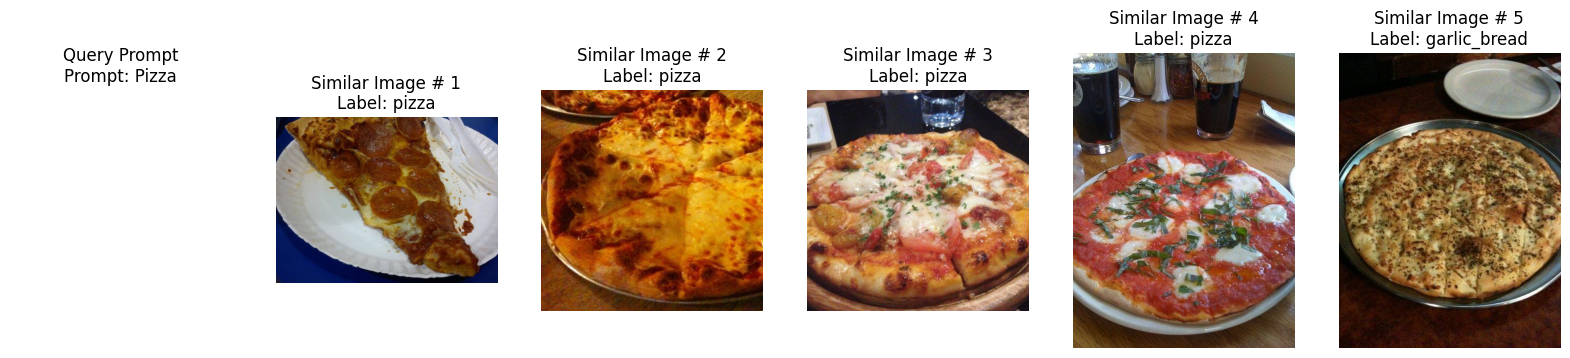

In [ ]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = labels[i]
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Prompt\n" + f"Prompt: {label_id}")
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[int(label_id)])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")

images = []
labels = []

for id, label in zip(sim_text_ids, sim_text_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["label"])

test_sample = np.zeros([100,100,3], dtype=np.uint8); test_sample.fill(255)
images.insert(0, test_sample)
labels.insert(0, prompt)
plot_images(images, labels)

## Image Search by Photo

Search for -  bruschetta


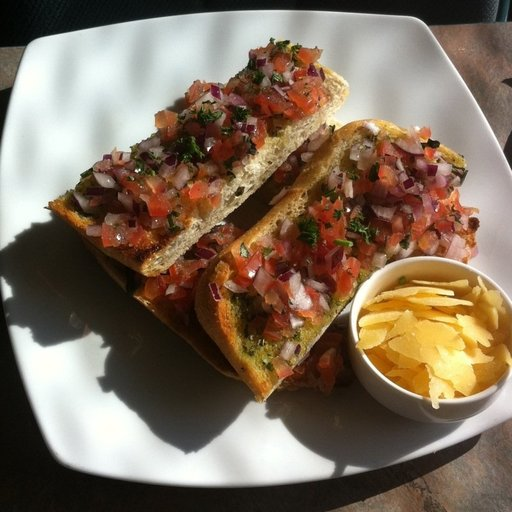

In [ ]:
test_idx = 1234
# Random - test_idx = np.random.choice(len(dataset["validation"]))

test_sample = dataset["validation"][test_idx]["image"]
test_label = dataset["validation"][test_idx]["label"]
print("Search for - ", id2label[test_label])

test_sample

In [ ]:
# Encode the image feature
image_prompt = image = preprocess(test_sample).unsqueeze(0)
image_feature = model.encode_image(image_prompt)
image_feature /= image_feature.norm(dim=-1, keepdim=True)
image_feature = image_feature.type(torch.DoubleTensor)

print("Check image feature shape: ", image_feature.shape)

Check image feature shape:  torch.Size([1, 512])


In [ ]:
sim_image_ids, sim_image_labels = fetch_clip_similar(image_feature)
print(f"Query Image Prompt: {test_label}")
print(f"Top 5 candidate labels: {sim_image_labels}")

Query Image Prompt: 10
Top 5 candidate labels: [10, 61, 15, 4, 10]


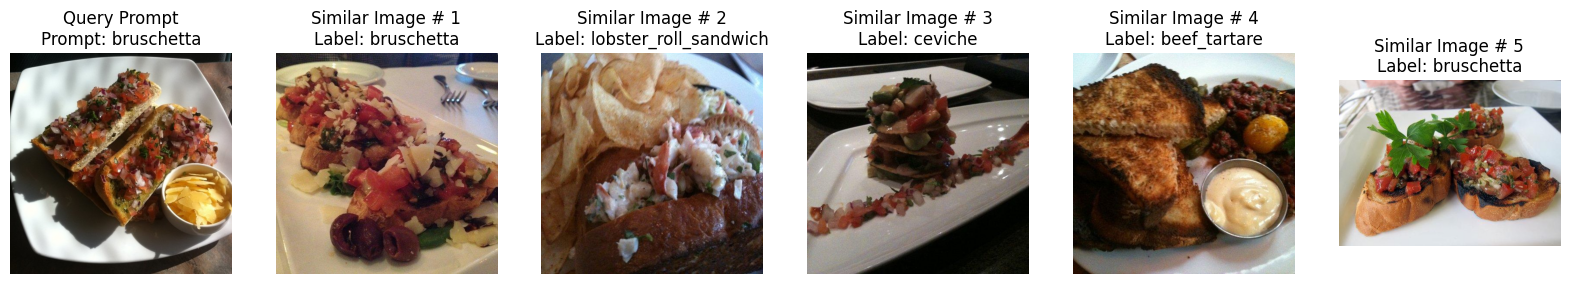

In [ ]:
images = []; labels = []

for id, label in zip(sim_image_ids, sim_image_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["label"])

images.insert(0, test_sample)
labels.insert(0, id2label[test_label])
plot_images(images, labels)